# Sales DB ETL → Analysis
**Objective:** Ingest raw CSVs into a local SQLite DB, run SQL aggregations to create dashboard-ready tables, export them as CSVs, and create visualizations for quick insights.

In [1]:
!pip install -q pandas sqlalchemy matplotlib seaborn jinja2

In [3]:
import os
from pathlib import Path
import sqlite3            # lightweight SQL DB (built-in)
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults for notebook
plt.rcParams['figure.figsize'] = (10,5)
sns.set_style('whitegrid')

# Change the path to a location where you have write permissions
# For example, use a directory in your user space
ROOT = Path.home() / 'my_project'  # Use your home directory instead of '..'
DATA_RAW = ROOT / 'data' / 'raw'
DATA_PROCESSED = ROOT / 'data' / 'processed'
DB_PATH = ROOT / 'data' / 'sales.db'   # sqlite file
SQL_DIR = ROOT / 'sql'
SCRIPTS_DIR = ROOT / 'scripts'
REPORTS_DIR = ROOT / 'reports' / 'figures'

# ensure directories exist
for p in [DATA_RAW, DATA_PROCESSED, SQL_DIR, SCRIPTS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT.resolve())
print("DB will be at:", DB_PATH)

ROOT: C:\Users\TOMBSTONE25\my_project
DB will be at: C:\Users\TOMBSTONE25\my_project\data\sales.db


In [4]:
# Create small sample datasets if you don't have real CSVs.
# This allows you to run the whole notebook end-to-end without external data.

# Sample customers
customers = pd.DataFrame({
    'customer_id': [1,2,3,4,5],
    'customer_name': ['A','B','C','D','E'],
    'region': ['North','South','East','West','North'],
    'signup_date': pd.to_datetime(['2023-01-10','2023-03-05','2023-03-20','2023-02-15','2023-05-01'])
})
customers.to_csv(DATA_RAW / 'customers.csv', index=False)

# Sample products
products = pd.DataFrame({
    'product_id':[101,102,103],
    'product_name':['Widget','Gadget','Doohickey'],
    'category':['A','B','A'],
    'price':[25.0, 45.0, 15.0]
})
products.to_csv(DATA_RAW / 'products.csv', index=False)

# Sample orders -- ensure order_date in ISO format (YYYY-MM-DD)
orders = pd.DataFrame({
    'order_id': [1001,1002,1003,1004,1005,1006],
    'customer_id':[1,2,1,3,4,5],
    'product_id':[101,102,101,103,102,101],
    'order_date': pd.to_datetime(['2023-01-15','2023-03-10','2023-02-01','2023-03-25','2023-02-20','2023-05-10']),
    'quantity':[2,1,1,3,2,1],
})
orders['total_amount'] = orders['quantity'] * orders['product_id'].map(products.set_index('product_id')['price'])
orders.to_csv(DATA_RAW / 'orders.csv', index=False)

print("Sample CSVs created:", list(DATA_RAW.iterdir()))


Sample CSVs created: [WindowsPath('C:/Users/TOMBSTONE25/my_project/data/raw/customers.csv'), WindowsPath('C:/Users/TOMBSTONE25/my_project/data/raw/orders.csv'), WindowsPath('C:/Users/TOMBSTONE25/my_project/data/raw/products.csv')]


In [8]:
# Create SQLAlchemy engine for SQLite. This file will be created if not present.
from sqlalchemy import create_engine, text  # Import text function

db_uri = f"sqlite:///{DB_PATH.as_posix()}"
engine = create_engine(db_uri, echo=False)   # echo=True prints SQL queries (debug)

# Quick test: open / close connection
with engine.connect() as conn:
    conn.execute(text("PRAGMA foreign_keys = ON;"))  # Use text() function to create executable SQL
    print("Connected to SQLite, foreign_keys ON")

Connected to SQLite, foreign_keys ON


In [10]:
# We read CSVs from data/raw and push to DB tables (overwrite mode).
customers_df = pd.read_csv(DATA_RAW / 'customers.csv', parse_dates=['signup_date'])
products_df  = pd.read_csv(DATA_RAW / 'products.csv')
orders_df    = pd.read_csv(DATA_RAW / 'orders.csv', parse_dates=['order_date'])

# Write to SQL (replace if existing)
customers_df.to_sql('customers', engine, if_exists='replace', index=False)
products_df.to_sql('products', engine, if_exists='replace', index=False)
orders_df.to_sql('orders', engine, if_exists='replace', index=False)

# Import text from sqlalchemy to properly format SQL statements
from sqlalchemy import text

# Create useful indexes to speed up queries (optional)
with engine.begin() as conn:
    # Wrap SQL statements with text() to make them executable objects
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_orders_order_date ON orders(order_date);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_orders_customer_id ON orders(customer_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_orders_product_id ON orders(product_id);"))

print("Wrote tables: customers, products, orders. Indexes created.")

Wrote tables: customers, products, orders. Indexes created.


In [11]:
# Show tables present
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", engine)
display(tables)

# Quick sample join (pull 10 rows)
q = """
SELECT o.order_id, o.order_date, o.customer_id, c.region, o.product_id, p.category, o.total_amount
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN products p ON o.product_id = p.product_id
ORDER BY o.order_date LIMIT 10;
"""
sample = pd.read_sql_query(q, engine, parse_dates=['order_date'])
sample.head()


,name
0,customers
1,products
2,orders


,order_id,order_date,customer_id,region,product_id,category,total_amount
0,1001,2023-01-15,1,North,101,A,50.0
1,1003,2023-02-01,1,North,101,A,25.0
2,1005,2023-02-20,4,West,102,B,90.0
3,1002,2023-03-10,2,South,102,B,45.0
4,1004,2023-03-25,3,East,103,A,45.0


In [12]:
# SQLite: use strftime('%Y-%m', order_date) to get month string e.g., '2023-03'
q_monthly = """
SELECT
    strftime('%Y-%m', order_date) AS month,
    SUM(total_amount) AS revenue,
    COUNT(DISTINCT customer_id) AS active_customers,
    COUNT(*) AS num_orders
FROM orders
GROUP BY month
ORDER BY month;
"""
monthly = pd.read_sql_query(q_monthly, engine)
monthly['month'] = pd.to_datetime(monthly['month'] + '-01')  # convert to date for plotting ease
monthly


,month,revenue,active_customers,num_orders
0,2023-01-01,50.0,1,1
1,2023-02-01,115.0,2,2
2,2023-03-01,90.0,2,2
3,2023-05-01,25.0,1,1


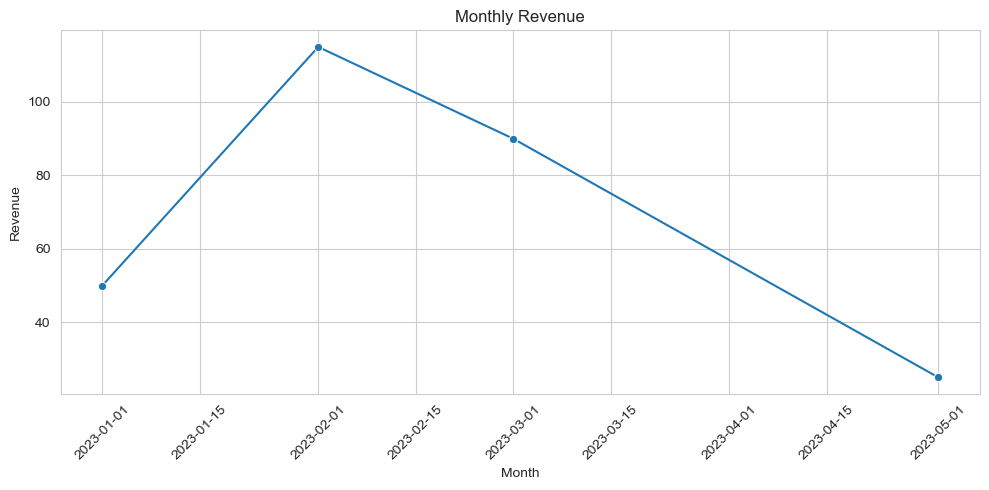

Saved: C:\Users\TOMBSTONE25\my_project\data\processed\monthly_revenue.csv


In [13]:
# Plot revenue time series
plt.figure()
sns.lineplot(data=monthly, x='month', y='revenue', marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save processed CSV (dashboard-ready)
monthly.to_csv(DATA_PROCESSED / 'monthly_revenue.csv', index=False)
print("Saved:", DATA_PROCESSED / 'monthly_revenue.csv')


In [14]:
q_top_customers = """
SELECT c.customer_id, c.customer_name, c.region, SUM(o.total_amount) AS total_revenue, COUNT(o.order_id) AS orders_count
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_id
ORDER BY total_revenue DESC
LIMIT 10;
"""
top_customers = pd.read_sql_query(q_top_customers, engine)
top_customers


,customer_id,customer_name,region,total_revenue,orders_count
0,4,D,West,90.0,1
1,1,A,North,75.0,2
2,3,C,East,45.0,1
3,2,B,South,45.0,1
4,5,E,North,25.0,1


In [15]:
# This SQL computes first purchase month per customer and joins to each order to get cohort vs order month
q_cohort = """
WITH first_orders AS (
    SELECT customer_id, MIN(order_date) AS first_order_date
    FROM orders
    GROUP BY customer_id
),
orders_with_cohort AS (
    SELECT
        o.customer_id,
        o.order_date,
        strftime('%Y-%m', o.order_date) AS order_month,
        strftime('%Y-%m', f.first_order_date) AS cohort_month
    FROM orders o
    JOIN first_orders f ON o.customer_id = f.customer_id
)
SELECT cohort_month, order_month, COUNT(DISTINCT customer_id) AS users
FROM orders_with_cohort
GROUP BY cohort_month, order_month
ORDER BY cohort_month, order_month;
"""

cohort_df = pd.read_sql_query(q_cohort, engine)
cohort_df['cohort_month'] = pd.to_datetime(cohort_df['cohort_month'] + '-01')
cohort_df['order_month'] = pd.to_datetime(cohort_df['order_month'] + '-01')
cohort_df.head()


,cohort_month,order_month,users
0,2023-01-01,2023-01-01,1
1,2023-01-01,2023-02-01,1
2,2023-02-01,2023-02-01,1
3,2023-03-01,2023-03-01,2
4,2023-05-01,2023-05-01,1


In [16]:
# Pivot to a cohort table: rows = cohort_month, columns = order_month, values = users
cohort_pivot = cohort_df.pivot_table(index='cohort_month', columns='order_month', values='users', aggfunc='sum').fillna(0)

# Convert counts to retention rates: divide each row by cohort size (users in cohort's first month)
cohort_sizes = cohort_pivot.iloc[:,0]   # number of users in cohort's first month (order month == cohort month)
retention = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

display(cohort_pivot)
display(retention)

# Save for dashboard
cohort_pivot.reset_index().to_csv(DATA_PROCESSED / 'cohort_counts.csv', index=False)
retention.reset_index().to_csv(DATA_PROCESSED / 'cohort_retention.csv', index=False)
print("Saved cohort CSVs to processed/")


order_month,2023-01-01,2023-02-01,2023-03-01,2023-05-01
cohort_month,,,,
2023-01-01,1.0,1.0,0.0,0.0
2023-02-01,0.0,1.0,0.0,0.0
2023-03-01,0.0,0.0,2.0,0.0
2023-05-01,0.0,0.0,0.0,1.0


order_month,2023-01-01,2023-02-01,2023-03-01,2023-05-01
cohort_month,,,,
2023-01-01,1.0,1.0,0.0,0.0
2023-02-01,NaN,inf,NaN,NaN
2023-03-01,NaN,NaN,inf,NaN
2023-05-01,NaN,NaN,NaN,inf


Saved cohort CSVs to processed/


In [17]:
# Example using SQL window function (works on modern SQLite versions)
q_cumrev = """
SELECT
    customer_id,
    order_date,
    total_amount,
    SUM(total_amount) OVER (PARTITION BY customer_id ORDER BY order_date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_revenue
FROM orders
ORDER BY customer_id, order_date;
"""
cumrev = pd.read_sql_query(q_cumrev, engine, parse_dates=['order_date'])
cumrev.head(10)


,customer_id,order_date,total_amount,cumulative_revenue
0,1,2023-01-15,50.0,50.0
1,1,2023-02-01,25.0,75.0
2,2,2023-03-10,45.0,45.0
3,3,2023-03-25,45.0,45.0
4,4,2023-02-20,90.0,90.0
5,5,2023-05-10,25.0,25.0


In [18]:
# Write aggregated tables back to the DB in a separate schema/table (so dashboard back-end can query directly)
monthly.to_sql('agg_monthly_revenue', engine, if_exists='replace', index=False)
top_customers.to_sql('agg_top_customers', engine, if_exists='replace', index=False)
cohort_pivot.reset_index().to_sql('agg_cohort_counts', engine, if_exists='replace', index=False)
retention.reset_index().to_sql('agg_cohort_retention', engine, if_exists='replace', index=False)

print("Materialized aggregated tables into DB: agg_monthly_revenue, agg_top_customers, agg_cohort_counts, agg_cohort_retention")


Materialized aggregated tables into DB: agg_monthly_revenue, agg_top_customers, agg_cohort_counts, agg_cohort_retention


In [19]:
# Optional: create a minimal Streamlit app that reads processed CSVs and shows the monthly revenue chart
app_code = f"""
import streamlit as st
import pandas as pd
import altair as alt

st.title('Sales Dashboard — Demo')

monthly = pd.read_csv('{(DATA_PROCESSED / 'monthly_revenue.csv').as_posix()}', parse_dates=['month'])
st.header('Monthly Revenue')
chart = alt.Chart(monthly).mark_line(point=True).encode(x='month:T', y='revenue:Q', tooltip=['month','revenue'])
st.altair_chart(chart, use_container_width=True)

st.header('Top Customers')
top = pd.read_csv('{(DATA_PROCESSED / 'cohort_counts.csv').as_posix()}', parse_dates=['cohort_month'])
st.write(top.head())
"""
with open(ROOT / 'app_streamlit.py', 'w') as f:
    f.write(app_code)
print("Wrote app_streamlit.py — run with: streamlit run app_streamlit.py")


Wrote app_streamlit.py — run with: streamlit run app_streamlit.py


In [20]:
# Write a reusable ETL script that you can run outside the notebook
etl_code = f'''
import pandas as pd
from sqlalchemy import create_engine
from pathlib import Path

ROOT = Path(__file__).parents[1]
DATA_RAW = ROOT / 'data' / 'raw'
DB_PATH = ROOT / 'data' / 'sales.db'

def run_etl():
    engine = create_engine("sqlite:///" + DB_PATH.as_posix())
    customers = pd.read_csv(DATA_RAW / 'customers.csv', parse_dates=['signup_date'])
    products = pd.read_csv(DATA_RAW / 'products.csv')
    orders = pd.read_csv(DATA_RAW / 'orders.csv', parse_dates=['order_date'])
    customers.to_sql('customers', engine, if_exists='replace', index=False)
    products.to_sql('products', engine, if_exists='replace', index=False)
    orders.to_sql('orders', engine, if_exists='replace', index=False)
    print("ETL completed: tables written to", DB_PATH)

if __name__ == "__main__":
    run_etl()
'''
with open(SCRIPTS_DIR / 'etl.py', 'w') as f:
    f.write(etl_code)
print("Wrote:", SCRIPTS_DIR / 'etl.py')


Wrote: C:\Users\TOMBSTONE25\my_project\scripts\etl.py


In [21]:
# Example: save the line plot as PNG for README or reports
fig_path = REPORTS_DIR / 'monthly_revenue.png'
fig = plt.figure()
sns.lineplot(data=monthly, x='month', y='revenue', marker='o')
plt.title('Monthly Revenue')
plt.tight_layout()
fig.savefig(fig_path)
plt.close(fig)
print("Saved figure:", fig_path)


Saved figure: C:\Users\TOMBSTONE25\my_project\reports\figures\monthly_revenue.png


In [22]:
engine.dispose()
print("Closed DB engine.")


Closed DB engine.
